## Bare pretrained Resnet backbone evaluation

In [124]:
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import cohen_kappa_score, classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd
import os
from torchsummary import summary
import numpy as np
from torch.nn import functional as F

BATCH = 32
label_names = ["D", "G", "A"]
device = "cuda" if torch.cuda.is_available() else "cpu"
efficient_net_dir = "../pretrained_backbone/ckpt_efficientnet_ep50.pt"

In [125]:
train_images= "../images/train"
train_labels = "../train.csv"
val_images = "../images/val"
val_labels = "../val.csv"
offsite_test_images = "../images/offsite_test"
offsite_test_labels = "../offsite_test.csv"
onsite_test_images = "../images/onsite_test"
onsite_test_labels = "../onsite_test_submission.csv"

In [126]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [127]:
import os
os.chdir("/content/drive/MyDrive/Projects/ODIR/task2_loss")

## Datasets

In [128]:
class RetinaMultiLabelDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.image_dir, row.iloc[0])
        img = Image.open(img_path).convert("RGB")
        labels = torch.tensor(row[1:].values.astype("float32"))
        if self.transform:
            img = self.transform(img)
        return img, labels

### Image transform

In [129]:
img_size=256
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

In [130]:
BATCH = 32

train = RetinaMultiLabelDataset(train_labels, train_images, transform = transform)
val = RetinaMultiLabelDataset(val_labels, val_images, transform = transform)

offsite_test = RetinaMultiLabelDataset(offsite_test_labels, offsite_test_images, transform = transform)
onsite_test = RetinaMultiLabelDataset(onsite_test_labels, onsite_test_images, transform = transform)


### Model

In [131]:
class Classifier(nn.Module):
    def __init__(self, backbone = "resnet", dir = None):
        super().__init__()

        if dir == None:
            raise FileNotFoundError
        layers = torch.load(dir)

        if backbone == "resnet":
            self.model = models.resnet18()
            self.model.fc = nn.Linear(self.model.fc.in_features, 3)
        elif backbone == "efficientnet":
            self.model = models.efficientnet_b0()
            self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, 3)
        else:
            raise ValueError("Unsupported backbone")
        self.model.load_state_dict(layers)

    def forward(self, X):
        return self.model(X)

model = Classifier(backbone="efficientnet", dir = efficient_net_dir).to(device)
summary(model, (3, 256, 256), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              SiLU-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]             288
       BatchNorm2d-5         [-1, 32, 128, 128]              64
              SiLU-6         [-1, 32, 128, 128]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 128, 128]               0
           Conv2d-13         [-1, 16, 128, 128]             512
      BatchNorm2d-14         [-1, 16, 1

## No fine-tuning: Evaluation directly on ODIR test set

In [132]:
def eval_model(model, dataset, csv_file = None, report = False):

    loader = DataLoader(dataset, BATCH, shuffle=False)
    preds = []
    model.eval()

    with torch.no_grad():
      for X, _ in tqdm(loader):
          output = (nn.functional.sigmoid(model(X.to(device))) > 0.5).long()
          preds.extend(output.cpu().numpy())

    preds = np.stack(preds)
    if report:
        cr = classification_report(dataset.data[label_names].to_numpy(), preds, target_names=label_names, zero_division= np.nan)
        print(cr)
    if csv_file:
        data = dataset.data.copy()
        data[label_names] = preds
        data.to_csv(csv_file, index = False)

### Onsite

In [133]:
# eval_model(model, offsite_test, report= True)

### Offsite

![](efficientnet_no_tuning.png)

In [134]:
# eval_model(model, onsite_test, "efficient_submission_notune.csv")

## Frozen backbone, fine-tuning classifier only

In [135]:
params = model.parameters()
for layer in params:
        layer.requires_grad = False
for param in model.model.classifier[1].parameters():
        param.requires_grad = True
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              SiLU-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]             288
       BatchNorm2d-5         [-1, 32, 128, 128]              64
              SiLU-6         [-1, 32, 128, 128]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 128, 128]               0
           Conv2d-13         [-1, 16, 128, 128]             512
      BatchNorm2d-14         [-1, 16, 1

In [136]:
checkpoints_dir = "../trained_models/"


def train_model(model, train_data, eval_data, optimizer, criterion, epochs, stepLR = None, checkpoint_name = None):
    train_loader = DataLoader(train_data,  BATCH, shuffle=True)
    val_loader = DataLoader(eval_data, BATCH, shuffle=False)
    train_size = len(train_data.data)
    eval_size = len(eval_data.data)

    train_losses = []
    val_losses = []

    f1 = []
    accuracy = []
    best_score = np.inf
    for i in range(epochs):
        model.train()
        train_loss = 0
        val_loss = 0
        val_f1 = 0
        val_accuracy = 0

        for (X, Y) in tqdm(train_loader, desc = "Training"):
            if device == "cuda":
                X = X.to(device)
                Y = Y.to(device)
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, Y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X.size(0)

        train_loss = train_loss / train_size

        model.eval()
        with torch.no_grad():
            for (X, Y) in tqdm(val_loader, desc="Validation"):
                if device == "cuda":
                    X = X.to(device)
                    Y = Y.to(device)
                output = model(X)
                loss = criterion(output, Y)
                val_loss += loss.item() * X.size(0)
                output = nn.functional.sigmoid(output)
                val_accuracy += accuracy_score((output > 0.5).cpu().long().numpy(), Y.cpu().numpy())
                val_f1 += f1_score((output > 0.5).cpu().long().numpy(), Y.cpu().numpy(),average='samples')

        val_loss = val_loss / eval_size
        val_accuracy /= np.ceil(eval_size/BATCH)
        val_f1 /= np.ceil(eval_size/BATCH)

        print(f"Epoch: {i} - Train Loss: {train_loss:2f} - Val Loss: {val_loss:2f} - Val Accuracy: {val_accuracy:2f} - Val F1 (avg. samples): {val_f1:2f}")
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        #saving model if score imporved
        if best_score > val_loss :
            print("Model improved! Saving if checkpoint_name is set.")
            best_score = val_loss
            if checkpoint_name != None:
                torch.save(model.state_dict(), checkpoints_dir + checkpoint_name)
        f1.append(val_f1)
        accuracy.append(val_accuracy)
        if stepLR != None:
                stepLR.step()

    x = range(0, epochs)
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(x, train_losses, label = "Train Loss")
    plt.plot(x, val_losses, label = "Val Loss")
    plt.legend()
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.title("BCE Loss")
    plt.subplot(1, 3, 2)
    plt.plot(x, f1)
    plt.title("Val F1 (avg. samples)")
    plt.xlabel("Epoch")
    plt.ylabel("Metric")
    plt.subplot(1, 3, 3)
    plt.plot(x, accuracy)
    plt.title("Val accuracy")
    plt.ylabel("Metric")
    plt.xlabel("Epoch")
    plt.show()

    return train_losses, val_losses, f1, accuracy

In [137]:


class ClassBalancedLoss(nn.Module):
    def __init__(self,
                 train_dataset,
                 beta=0.999,
                 reduction='mean',
                 task_type='multi-label'):
        """
        Class-Balanced Loss using effective number of samples.

        Args:
            train_dataset: a dataset whose __getitem__ returns (image, label)
                           label must be a tensor of shape (C,) with 0/1 entries.
            beta: float in [0,1). Usually 0.9–0.999.
            reduction: 'none' | 'mean' | 'sum'
            task_type: 'binary', 'multi-class', or 'multi-label'
        """
        super(ClassBalancedLoss, self).__init__()

        assert train_dataset is not None, "You must provide the training dataset."
        assert beta >= 0 and beta < 1, "beta must be in [0, 1)"

        self.beta = beta
        self.reduction = reduction
        self.task_type = task_type

        # obtain lables
        all_labels = []

        for i in range(len(train_dataset)):
            item = train_dataset[i]
            label = item[1]  # assume dataset returns (image, label)
            all_labels.append(label)

        labels_tensor = torch.stack(all_labels, dim=0).float()  # shape (N, C)

        # loss calculations
        samples_per_class = torch.sum(labels_tensor, dim=0).float()
        samples_per_class = torch.clamp(samples_per_class, min=1.0)

        effective_num = 1.0 - torch.pow(beta, samples_per_class)
        class_weights = (1.0 - beta) / effective_num  # shape (C,)
        class_weights = class_weights / class_weights.sum() * len(samples_per_class)

        self.register_buffer("class_weights", class_weights)
        self.num_classes = samples_per_class.shape[0]

    def forward(self, inputs, targets):
        """
        inputs: logits (B, C)
        targets: 0/1 labels (B, C)
        """
        if self.task_type == 'multi-label':
            return self.multi_label_cb_loss(inputs, targets, self.class_weights)
        else:
            raise ValueError("For ODIR you should use task_type='multi-label'.")

    def multi_label_cb_loss(self, inputs, targets, class_weights):
        """
        Multi-label CB loss: class-weighted BCE per label.
        """
        bce = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')  # (B, C)

        w = class_weights.view(1, -1)

        loss = bce * w

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

Validation: 100%|██████████| 7/7 [00:01<00:00,  5.75it/s]


Epoch: 0 - Train Loss: 0.972265 - Val Loss: 1.245889 - Val Accuracy: 0.196429 - Val F1 (avg. samples): 0.316964
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.11it/s]


Epoch: 1 - Train Loss: 0.959572 - Val Loss: 1.154101 - Val Accuracy: 0.218750 - Val F1 (avg. samples): 0.342262
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.21it/s]


Epoch: 2 - Train Loss: 0.966667 - Val Loss: 1.139196 - Val Accuracy: 0.227679 - Val F1 (avg. samples): 0.348214
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.07it/s]


Epoch: 3 - Train Loss: 0.975552 - Val Loss: 1.114684 - Val Accuracy: 0.223214 - Val F1 (avg. samples): 0.346726
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.19it/s]


Epoch: 4 - Train Loss: 0.945819 - Val Loss: 1.117059 - Val Accuracy: 0.236607 - Val F1 (avg. samples): 0.357143


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.02it/s]


Epoch: 5 - Train Loss: 0.954924 - Val Loss: 1.108205 - Val Accuracy: 0.223214 - Val F1 (avg. samples): 0.343750
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.92it/s]


Epoch: 6 - Train Loss: 0.927746 - Val Loss: 1.094565 - Val Accuracy: 0.232143 - Val F1 (avg. samples): 0.352679
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.12it/s]


Epoch: 7 - Train Loss: 0.949514 - Val Loss: 1.108472 - Val Accuracy: 0.223214 - Val F1 (avg. samples): 0.343750


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.75it/s]


Epoch: 8 - Train Loss: 0.931335 - Val Loss: 1.086346 - Val Accuracy: 0.241071 - Val F1 (avg. samples): 0.355655
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.15it/s]


Epoch: 9 - Train Loss: 0.920818 - Val Loss: 1.074199 - Val Accuracy: 0.258929 - Val F1 (avg. samples): 0.370536
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.95it/s]


Epoch: 10 - Train Loss: 0.911893 - Val Loss: 1.076339 - Val Accuracy: 0.223214 - Val F1 (avg. samples): 0.343006


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.08it/s]


Epoch: 11 - Train Loss: 0.897204 - Val Loss: 1.072933 - Val Accuracy: 0.250000 - Val F1 (avg. samples): 0.364583
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.77it/s]


Epoch: 12 - Train Loss: 0.917533 - Val Loss: 1.067700 - Val Accuracy: 0.236607 - Val F1 (avg. samples): 0.354167
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.25it/s]


Epoch: 13 - Train Loss: 0.893847 - Val Loss: 1.051462 - Val Accuracy: 0.236607 - Val F1 (avg. samples): 0.354167
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.74it/s]


Epoch: 14 - Train Loss: 0.890133 - Val Loss: 1.040140 - Val Accuracy: 0.236607 - Val F1 (avg. samples): 0.354167
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.45it/s]


Epoch: 15 - Train Loss: 0.900641 - Val Loss: 1.038407 - Val Accuracy: 0.241071 - Val F1 (avg. samples): 0.355655
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.85it/s]


Epoch: 16 - Train Loss: 0.883573 - Val Loss: 1.037128 - Val Accuracy: 0.241071 - Val F1 (avg. samples): 0.358631
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.02it/s]


Epoch: 17 - Train Loss: 0.859724 - Val Loss: 1.037378 - Val Accuracy: 0.232143 - Val F1 (avg. samples): 0.343750


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.93it/s]


Epoch: 18 - Train Loss: 0.846282 - Val Loss: 1.034813 - Val Accuracy: 0.232143 - Val F1 (avg. samples): 0.349702
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.58it/s]


Epoch: 19 - Train Loss: 0.878754 - Val Loss: 1.014095 - Val Accuracy: 0.241071 - Val F1 (avg. samples): 0.355655
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.79it/s]


Epoch: 20 - Train Loss: 0.864008 - Val Loss: 1.022045 - Val Accuracy: 0.236607 - Val F1 (avg. samples): 0.351190


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.56it/s]


Epoch: 21 - Train Loss: 0.852036 - Val Loss: 1.009729 - Val Accuracy: 0.241071 - Val F1 (avg. samples): 0.358631
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.88it/s]


Epoch: 22 - Train Loss: 0.875206 - Val Loss: 1.007577 - Val Accuracy: 0.241071 - Val F1 (avg. samples): 0.358631
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.34it/s]


Epoch: 23 - Train Loss: 0.842066 - Val Loss: 1.005886 - Val Accuracy: 0.254464 - Val F1 (avg. samples): 0.369048
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.82it/s]


Epoch: 24 - Train Loss: 0.860954 - Val Loss: 1.004135 - Val Accuracy: 0.258929 - Val F1 (avg. samples): 0.373512
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.94it/s]


Epoch: 25 - Train Loss: 0.856795 - Val Loss: 0.997138 - Val Accuracy: 0.241071 - Val F1 (avg. samples): 0.358631
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.70it/s]


Epoch: 26 - Train Loss: 0.857851 - Val Loss: 0.995331 - Val Accuracy: 0.250000 - Val F1 (avg. samples): 0.357887
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.61it/s]


Epoch: 27 - Train Loss: 0.875162 - Val Loss: 0.984779 - Val Accuracy: 0.258929 - Val F1 (avg. samples): 0.376488
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.86it/s]


Epoch: 28 - Train Loss: 0.844373 - Val Loss: 0.989512 - Val Accuracy: 0.236607 - Val F1 (avg. samples): 0.351190


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.65it/s]


Epoch: 29 - Train Loss: 0.842193 - Val Loss: 0.960868 - Val Accuracy: 0.263393 - Val F1 (avg. samples): 0.377976
Model improved! Saving if checkpoint_name is set.


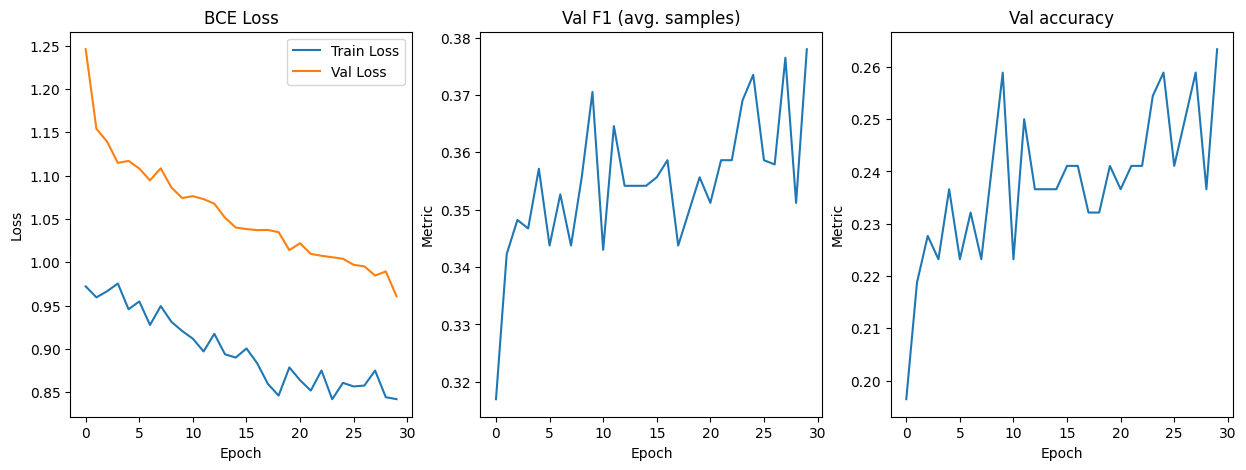

In [138]:
optimizer = torch.optim.AdamW(model.model.classifier[1].parameters(), lr = 1e-5)
criterion = ClassBalancedLoss(train).to(device)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=10, gamma=0.8)
result = train_model(model, train, val, optimizer, criterion, epochs=30, stepLR=scheduler, checkpoint_name="efficient_tuned_classifer.pt")

### Offsite test

In [139]:
model = Classifier(backbone="efficientnet", dir = efficient_net_dir).to(device)
model.load_state_dict(torch.load(checkpoints_dir + "efficient_tuned_classifer.pt"))
eval_model(model, offsite_test, report= True)

100%|██████████| 7/7 [00:01<00:00,  5.31it/s]

              precision    recall  f1-score   support

           D       0.74      0.51      0.61       140
           G       0.56      0.41      0.47        49
           A       0.48      0.59      0.53        22

   micro avg       0.66      0.50      0.57       211
   macro avg       0.59      0.50      0.54       211
weighted avg       0.67      0.50      0.57       211
 samples avg       0.70      0.49      0.45       211



### Onsite test
![](efficientnet_classifier_tuning.png)

In [140]:
eval_model(model, onsite_test, "efficient_net_submission_classifier_tune_cb_loss.csv")

100%|██████████| 8/8 [00:01<00:00,  5.10it/s]


## Full fine-tuning

Only 3 epochs no more, usually overfits after epoch 1, lr = 1e-4 seem to be most optimal, no weight decay

Validation: 100%|██████████| 7/7 [00:01<00:00,  5.60it/s]


Epoch: 0 - Train Loss: 0.594726 - Val Loss: 0.517754 - Val Accuracy: 0.446429 - Val F1 (avg. samples): 0.568452
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.40it/s]


Epoch: 1 - Train Loss: 0.303949 - Val Loss: 0.448927 - Val Accuracy: 0.531250 - Val F1 (avg. samples): 0.620536
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.29it/s]


Epoch: 2 - Train Loss: 0.196780 - Val Loss: 0.460066 - Val Accuracy: 0.571429 - Val F1 (avg. samples): 0.663690


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.33it/s]


Epoch: 3 - Train Loss: 0.128839 - Val Loss: 0.444548 - Val Accuracy: 0.602679 - Val F1 (avg. samples): 0.700893
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.57it/s]


Epoch: 4 - Train Loss: 0.105361 - Val Loss: 0.458421 - Val Accuracy: 0.616071 - Val F1 (avg. samples): 0.720238


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.25it/s]


Epoch: 5 - Train Loss: 0.083573 - Val Loss: 0.465416 - Val Accuracy: 0.620536 - Val F1 (avg. samples): 0.724702


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.34it/s]


Epoch: 6 - Train Loss: 0.061908 - Val Loss: 0.487051 - Val Accuracy: 0.642857 - Val F1 (avg. samples): 0.735119


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.74it/s]


Epoch: 7 - Train Loss: 0.053340 - Val Loss: 0.484525 - Val Accuracy: 0.638393 - Val F1 (avg. samples): 0.745536


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.43it/s]


Epoch: 8 - Train Loss: 0.045274 - Val Loss: 0.506458 - Val Accuracy: 0.642857 - Val F1 (avg. samples): 0.758929


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.51it/s]


Epoch: 9 - Train Loss: 0.031310 - Val Loss: 0.514423 - Val Accuracy: 0.642857 - Val F1 (avg. samples): 0.761905


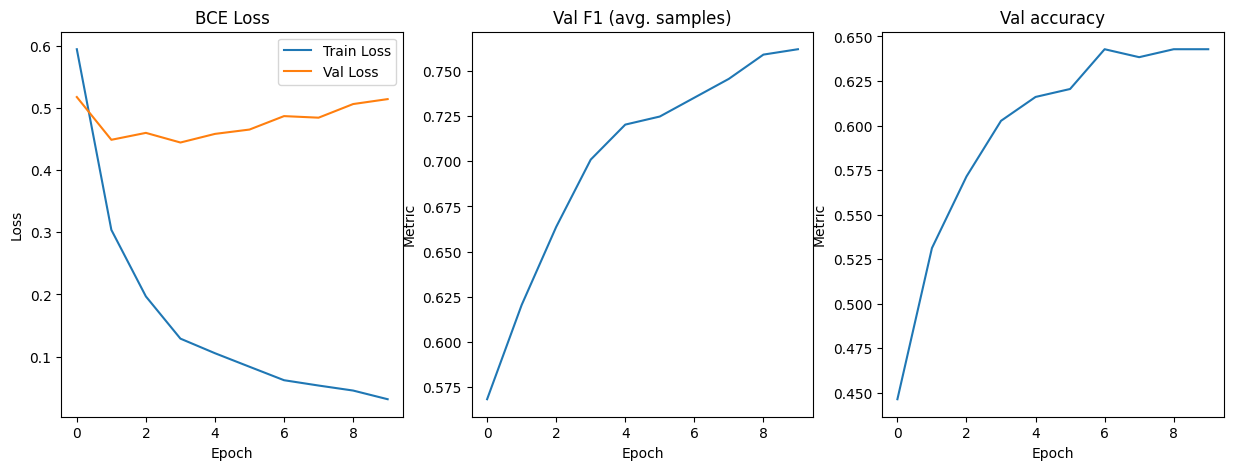

In [141]:
for layer in model.parameters():
    layer.requires_grad = True

optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)
criterion = ClassBalancedLoss(train).to(device)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.5)
result = train_model(model, train, val, optimizer=optimizer, criterion=criterion, epochs=10, stepLR=scheduler, checkpoint_name="efficient.pt")

### Offsite

In [142]:
model = Classifier(backbone="efficientnet", dir = efficient_net_dir).to(device)
model.load_state_dict(torch.load(checkpoints_dir + "efficient.pt"))
eval_model(model, offsite_test, report= True)

100%|██████████| 7/7 [00:01<00:00,  6.09it/s]

              precision    recall  f1-score   support

           D       0.85      0.81      0.83       140
           G       0.74      0.53      0.62        49
           A       0.46      0.59      0.52        22

   micro avg       0.78      0.73      0.75       211
   macro avg       0.69      0.65      0.66       211
weighted avg       0.79      0.73      0.75       211
 samples avg       0.79      0.74      0.73       211



### Onsite test
![](efficientnet_classifier_full.png)

In [143]:
eval_model(model, onsite_test, "efficient_net_submission_full_cb_loss.csv")

100%|██████████| 8/8 [00:01<00:00,  5.48it/s]
